## 1. 导入库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 设置随机种子
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# 设备检测
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA 版本: {torch.version.cuda}")
    print(f"GPU 设备: {torch.cuda.get_device_name(0)}")
    print(f"GPU 显存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print(f"使用设备: {device}")
print("✅ 库导入完成")

PyTorch 版本: 2.5.1+cu121
CUDA 可用: True
CUDA 版本: 12.1
GPU 设备: NVIDIA GeForce RTX 3060 Laptop GPU
GPU 显存: 6.0 GB
使用设备: cuda
✅ 库导入完成


## 2. 加载数据

In [2]:
# 加载数据
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# 转换时间戳
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])
test_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])

# 按时间排序
train_df = train_df.sort_values('Timestamp').reset_index(drop=True)
test_df = test_df.sort_values('Timestamp').reset_index(drop=True)

print(f"训练集形状: {train_df.shape}")
print(f"测试集形状: {test_df.shape}")
print(f"\n训练集时间范围: {train_df['Timestamp'].min()} 到 {train_df['Timestamp'].max()}")
print(f"测试集时间范围: {test_df['Timestamp'].min()} 到 {test_df['Timestamp'].max()}")

训练集形状: (484202, 7)
测试集形状: (2881, 6)

训练集时间范围: 2012-01-01 10:00:00 到 2025-10-23 23:15:00
测试集时间范围: 2025-10-23 23:30:00 到 2025-11-22 23:30:00


## 3. 特征工程

In [3]:
def create_features(df):
    """创建技术指标特征"""
    df = df.copy()
    
    # 收益率
    df['returns'] = df['Close'].pct_change()
    df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # 移动平均
    for window in [5, 10, 20]:
        df[f'ma_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'ma_ratio_{window}'] = df['Close'] / df[f'ma_{window}']
    
    # 波动率
    df['volatility_10'] = df['returns'].rolling(window=10).std()
    df['volatility_20'] = df['returns'].rolling(window=20).std()
    
    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    
    # 价格范围
    df['high_low_ratio'] = df['High'] / (df['Low'] + 1e-10)
    df['close_open_ratio'] = df['Close'] / (df['Open'] + 1e-10)
    
    # 成交量
    df['volume_ma_10'] = df['Volume'].rolling(window=10).mean()
    df['volume_ratio'] = df['Volume'] / (df['volume_ma_10'] + 1e-10)
    
    return df

# 创建特征
train_featured = create_features(train_df)
test_featured = create_features(test_df)

print(f"特征后训练集列数: {train_featured.shape[1]}")

特征后训练集列数: 23


In [4]:
# 定义特征列
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'returns', 'log_returns',
                'ma_ratio_5', 'ma_ratio_10', 'ma_ratio_20',
                'volatility_10', 'volatility_20',
                'rsi', 'macd',
                'high_low_ratio', 'close_open_ratio', 'volume_ratio']

print(f"特征数量: {len(feature_cols)}")
print(f"特征列表: {feature_cols}")

特征数量: 17
特征列表: ['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'log_returns', 'ma_ratio_5', 'ma_ratio_10', 'ma_ratio_20', 'volatility_10', 'volatility_20', 'rsi', 'macd', 'high_low_ratio', 'close_open_ratio', 'volume_ratio']


## 4. 数据预处理

In [5]:
# 删除 NaN
train_clean = train_featured.dropna().reset_index(drop=True)
print(f"清洗后数据: {train_clean.shape}")

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_clean[feature_cols])
y = train_clean['Target'].values

print(f"X 形状: {X_scaled.shape}")
print(f"y 形状: {y.shape}")

清洗后数据: (484182, 23)
X 形状: (484182, 17)
y 形状: (484182,)
X 形状: (484182, 17)
y 形状: (484182,)


In [6]:
# 创建序列数据
SEQ_LEN = 60  # 使用过去60个时间步

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, SEQ_LEN)
print(f"序列 X 形状: {X_seq.shape}")
print(f"序列 y 形状: {y_seq.shape}")

序列 X 形状: (484122, 60, 17)
序列 y 形状: (484122,)


In [7]:
# 时序分割
train_size = int(len(X_seq) * 0.8)

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_val = X_seq[train_size:]
y_val = y_seq[train_size:]

print(f"训练集: {X_train.shape}")
print(f"验证集: {X_val.shape}")

# 转为 PyTorch Tensor
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train).unsqueeze(1)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val).unsqueeze(1)

# 创建 DataLoader
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n训练 batches: {len(train_loader)}")
print(f"验证 batches: {len(val_loader)}")

训练集: (387297, 60, 17)
验证集: (96825, 60, 17)

训练 batches: 6052
验证 batches: 1513

训练 batches: 6052
验证 batches: 1513


## 5. 定义 Transformer 模型

In [8]:
class CryptoTransformer(nn.Module):
    def __init__(self, feature_size, d_model=128, nhead=4, num_layers=3, dropout=0.1, seq_len=60):
        super(CryptoTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.d_model = d_model
        
        # 1. Input Embedding
        self.embedding = nn.Linear(feature_size, d_model)
        self.embed_norm = nn.LayerNorm(d_model)
        
        # 2. Positional Encoding (可学习)
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_len, d_model) * 0.02)
        
        # 3. Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model, nhead, 
            dim_feedforward=d_model*4, 
            dropout=dropout, 
            batch_first=True,
            norm_first=True  # Pre-LN 更稳定
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # 4. Output Head - 只用最后一个时间步
        self.decoder = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, src):
        # src: [Batch, Seq_Len, Features]
        
        # Embedding
        x = self.embedding(src)
        x = self.embed_norm(x)
        
        # Add Position
        x = x + self.pos_encoder
        
        # Transformer
        x = self.transformer_encoder(x)
        
        # 只用最后一个时间步预测（而不是flatten全部）
        x = x[:, -1, :]  # [Batch, d_model]
        
        # Prediction
        output = self.decoder(x)
        return output

# 创建模型
model = CryptoTransformer(
    feature_size=len(feature_cols),
    d_model=128,
    nhead=4,
    num_layers=3,
    dropout=0.1,
    seq_len=SEQ_LEN
).to(device)

print(model)
print(f"\n模型参数量: {sum(p.numel() for p in model.parameters()):,}")

CryptoTransformer(
  (embedding): Linear(in_features=17, out_features=128, bias=True)
  (embed_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2)

## 6. 训练模型

In [9]:
# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)  # AdamW + 权重衰减
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)  # Cosine退火

# 训练参数
EPOCHS = 3 #benlai 30
best_val_loss = float('inf')
patience = 8
patience_counter = 0

train_losses = []
val_losses = []

print("开始训练...\n")
print(f"初始学习率: {optimizer.param_groups[0]['lr']}")

开始训练...

初始学习率: 0.0005


In [10]:
for epoch in range(EPOCHS):
    # 训练阶段
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # 验证阶段
    model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
            val_preds.extend(output.cpu().numpy().flatten())
            val_targets.extend(y_batch.cpu().numpy().flatten())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # 计算预测的标准差（监控是否输出常数）
    pred_std = np.std(val_preds)
    
    # 学习率调整
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Train: {train_loss:.6f} - Val: {val_loss:.6f} - Pred Std: {pred_std:.6f} - LR: {current_lr:.6f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '../models/transformer_best.pth')
        print(f"  ✓ 保存最佳模型")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print("\n✅ 训练完成!")

Epoch 1/3 - Train: 0.001383 - Val: 0.000006 - Pred Std: 0.000008 - LR: 0.000499
  ✓ 保存最佳模型
Epoch 2/3 - Train: 0.000036 - Val: 0.000006 - Pred Std: 0.000000 - LR: 0.000495
Epoch 2/3 - Train: 0.000036 - Val: 0.000006 - Pred Std: 0.000000 - LR: 0.000495
Epoch 3/3 - Train: 0.000036 - Val: 0.000008 - Pred Std: 0.000000 - LR: 0.000488

✅ 训练完成!
Epoch 3/3 - Train: 0.000036 - Val: 0.000008 - Pred Std: 0.000000 - LR: 0.000488

✅ 训练完成!


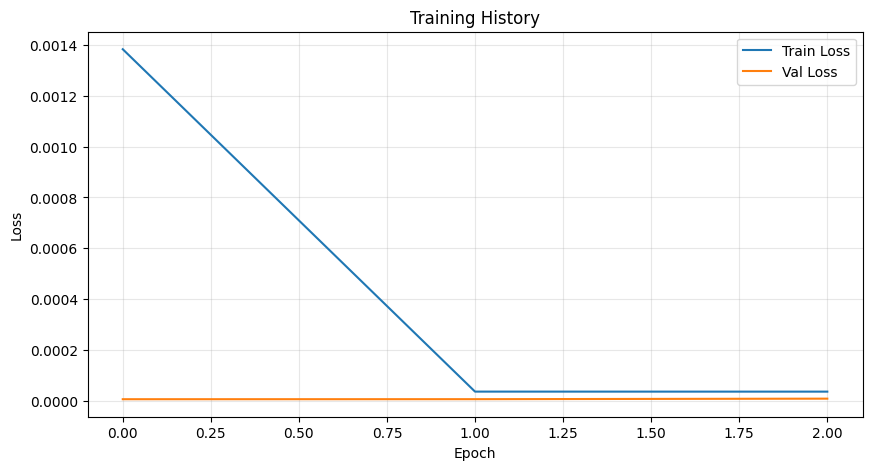

In [11]:
# 绘制训练曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. 模型评估

In [12]:
# 加载最佳模型
model.load_state_dict(torch.load('../models/transformer_best.pth'))
model.eval()

# 清理GPU缓存
torch.cuda.empty_cache()

# 分批预测验证集（避免OOM）
val_pred = []
batch_size = 256  # 小批量预测

with torch.no_grad():
    for i in range(0, len(X_val_t), batch_size):
        batch = X_val_t[i:i+batch_size].to(device)
        pred = model(batch).cpu().numpy().flatten()
        val_pred.extend(pred)
        del batch  # 释放显存
        torch.cuda.empty_cache()

val_pred = np.array(val_pred)

# 评估
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
r2 = r2_score(y_val, val_pred)
corr = np.corrcoef(y_val, val_pred)[0, 1]

print(f"验证集评估:")
print(f"  RMSE: {rmse:.6f}")
print(f"  R²: {r2:.6f}")
print(f"  Correlation: {corr:.6f}")

验证集评估:
  RMSE: 0.002499
  R²: -0.004068
  Correlation: 0.002044


## 8. 测试集预测

In [13]:
# 准备测试数据
# 需要训练集尾部数据来构建序列
train_tail = train_clean.tail(SEQ_LEN + 100).copy()

# 合并
test_with_history = pd.concat([train_tail, test_featured], ignore_index=True)
test_with_history = test_with_history.fillna(method='ffill').fillna(method='bfill')

# 标准化
X_test_scaled = scaler.transform(test_with_history[feature_cols])

# 创建序列
X_test_seq = []
for i in range(SEQ_LEN, len(X_test_scaled)):
    X_test_seq.append(X_test_scaled[i-SEQ_LEN:i])
X_test_seq = np.array(X_test_seq)

# 只取测试集部分
n_test = len(test_df)
X_test_seq = X_test_seq[-n_test:]

print(f"测试序列形状: {X_test_seq.shape}")

测试序列形状: (2881, 60, 17)


In [14]:
# 清理GPU缓存
torch.cuda.empty_cache()

# 分批预测（避免OOM）
test_predictions = []
batch_size = 256

model.eval()
with torch.no_grad():
    for i in range(0, len(X_test_seq), batch_size):
        batch = torch.FloatTensor(X_test_seq[i:i+batch_size]).to(device)
        pred = model(batch).cpu().numpy().flatten()
        test_predictions.extend(pred)
        del batch
        torch.cuda.empty_cache()

test_predictions = np.array(test_predictions)

print(f"预测数量: {len(test_predictions)}")
print(f"预测均值: {test_predictions.mean():.6f}")
print(f"预测标准差: {test_predictions.std():.6f}")

预测数量: 2881
预测均值: 0.000176
预测标准差: 0.000005


## 9. 生成提交文件

In [15]:
# 创建提交文件
submission_df = pd.DataFrame({
    'Timestamp': test_df['Timestamp'].values[:len(test_predictions)],
    'Prediction': test_predictions
})

# 保存
submission_dir = Path('../submissions')
submission_dir.mkdir(exist_ok=True)

submission_file = submission_dir / 'transformer_submission.csv'
submission_df.to_csv(submission_file, index=False)

print(f"✅ 提交文件已保存: {submission_file}")
print(f"\n提交文件预览:")
print(submission_df.head(10))
print(f"\n预测统计:")
print(submission_df['Prediction'].describe())

✅ 提交文件已保存: ..\submissions\transformer_submission.csv

提交文件预览:
            Timestamp  Prediction
0 2025-10-23 23:30:00    0.000176
1 2025-10-23 23:45:00    0.000176
2 2025-10-24 00:00:00    0.000176
3 2025-10-24 00:15:00    0.000176
4 2025-10-24 00:30:00    0.000176
5 2025-10-24 00:45:00    0.000177
6 2025-10-24 01:00:00    0.000178
7 2025-10-24 01:15:00    0.000178
8 2025-10-24 01:30:00    0.000175
9 2025-10-24 01:45:00    0.000177

预测统计:
count    2881.000000
mean        0.000176
std         0.000005
min         0.000149
25%         0.000174
50%         0.000177
75%         0.000179
max         0.000215
Name: Prediction, dtype: float64


提交文件预览:
            Timestamp  Prediction
0 2025-10-23 23:30:00    0.000176
1 2025-10-23 23:45:00    0.000176
2 2025-10-24 00:00:00    0.000176
3 2025-10-24 00:15:00    0.000176
4 2025-10-24 00:30:00    0.000176
5 2025-10-24 00:45:00    0.000177
6 2025-10-24 01:00:00    0.000178
7 2025-10-24 01:15:00    0.000178
8 2025-10-24 01:30:00    0.000175
9 2025

## 10. 保存模型

In [16]:
# 保存最终模型
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'feature_cols': feature_cols,
    'seq_len': SEQ_LEN,
}, model_dir / 'transformer_model.pth')

import joblib
joblib.dump(scaler, model_dir / 'transformer_scaler.pkl')

print("✅ 模型已保存")

✅ 模型已保存


## 总结

### Transformer 模型架构:
1. **Input Embedding**: 将特征映射到 d_model 维度
2. **Learnable Position Encoding**: 学习时间位置信息
3. **Transformer Encoder**: 自注意力机制捕捉时序依赖
4. **Decoder Head**: 全连接层输出预测值

### 优势:
- 自注意力机制能捕捉长距离依赖
- 并行计算效率高
- 可解释性好（注意力权重）